### EDFA Gain Modelling with Machine Learning

#### Step 1.Data Collection and Preprocessing

In [11]:
import pandas as pd

# File paths for each dataset
datasets = {
    'train': 'train_file.csv',
    'test_random': 'test_random.csv',
    'test_goalpost': 'test_goalpost.csv',
}

# Dictionary to store memory usage of each dataset
memory_usage_dict = {}

# First, calculate the memory usage of each dataset and total memory usage
total_memory = 0
for name, path in datasets.items():
    # Load the dataset
    df = pd.read_csv(path)
    
    # Calculate memory usage in MB
    memory_mb = df.memory_usage(deep=True).sum() / (1024**2)
    
    # Store memory usage
    memory_usage_dict[name] = memory_mb
    
    # Update total memory usage
    total_memory += memory_mb
    
    # Delete the dataframe to free up memory
    del df

# Header for the output table
print(f"{'Dataset Name':<15} | {'Shape (Rows, Columns)':<25} | {'Memory (MB)':<15} | {'% of Total':<15}")
print("-" * 80)

# Now print the shape, memory usage, and percentage for each dataset
for name, path in datasets.items():
    # Reload the dataset to get its shape
    df = pd.read_csv(path)
    
    # Get memory usage from the dictionary
    memory_mb = memory_usage_dict[name]
    
    # Calculate percentage of total memory
    memory_percentage = (memory_mb / total_memory) * 100
    
    # Print the dataset name, shape, memory usage, and percentage
    print(f"{name:<15} | {df.shape}               | {memory_mb:.2f} MB      | {memory_percentage:.2f}%")
    
    # Delete the dataframe to free up memory
    del df

# Line for separation
print("-" * 80)

# Print total memory usage
print(f"Total Memory Usage: {total_memory:.2f} MB")


Dataset Name    | Shape (Rows, Columns)     | Memory (MB)     | % of Total     
--------------------------------------------------------------------------------
train           | (128688, 384)               | 377.02 MB      | 86.01%
test_random     | (10560, 384)               | 30.94 MB      | 7.06%
test_goalpost   | (10368, 384)               | 30.38 MB      | 6.93%
--------------------------------------------------------------------------------
Total Memory Usage: 438.33 MB


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import warnings
import pickle
import gc
warnings.filterwarnings("ignore")

# Path to the datasets folder
# folder_path = 'path_to_your_datasets/'  # Replace with your actual path
folder_path = "D:\\class\\Modules\\ICE-4001 Individual Project\\EDFA_Gain_Model"

# List of datasets
db_values = [15, 18, 21, 24, 27]

datasets = {
    'train': [f'train_file_{db}dB.csv' for db in db_values],
    'test_random': [f'test_random_{db}dB.csv' for db in db_values],
    'test_goalpost': [f'test_goalpost_{db}dB.csv' for db in db_values],
}

# Function to convert dB to linear scale
def db_to_linear(db_value):
    return 10 ** (db_value / 10)

# Function to preprocess data
def preprocess_data(df):
    channels_data = []
    for i in range(95):
        channel_index = f'{i:02d}'
        input_power = df[f'EDFA_input_spectra_{channel_index}'].apply(db_to_linear)
        power_index = df[f'DUT_WSS_activated_channel_index_{channel_index}']
        output_power = df[f'EDFA_output_spectra_{channel_index}'].apply(db_to_linear)
        gain = df[f'calculated_gain_spectra_{channel_index}'].apply(db_to_linear)

        channel_data = {
            'effective_input_power': input_power * power_index,
            'power_index': power_index,
            'output_power': output_power,
            'gain': gain  # This is the actual gain from the dataset
        }
        channels_data.append(pd.DataFrame(channel_data))

    # Concatenate all channels data into a single DataFrame
    all_channels_df = pd.concat(channels_data, axis=1, keys=range(95))

    # Flatten the multi-index columns
    all_channels_df.columns = [f'{outer}_{inner}' for outer, inner in all_channels_df.columns]

    return all_channels_df

# Function to prepare data for training and testing
def prepare_data(train_df, test_random_df, test_goalpost_df, fixed_gain_db):
    train_data = preprocess_data(train_df)
    test_random_data = preprocess_data(test_random_df)
    test_goalpost_data = preprocess_data(test_goalpost_df)

    X_train = train_data.filter(regex='effective_input_power|gain')
    y_train = train_data.filter(regex='output_power')

    X_test_random = test_random_data.filter(regex='effective_input_power|gain')
    y_test_random = test_random_data.filter(regex='output_power')

    X_test_goalpost = test_goalpost_data.filter(regex='effective_input_power|gain')
    y_test_goalpost = test_goalpost_data.filter(regex='output_power')

    return X_train, y_train, X_test_random, y_test_random, X_test_goalpost, y_test_goalpost


#### Step 2. Deep Neural Network (DNN) Model and Model Evaluation

In [23]:
# Lists to store results
mae_train_list_dnn = []
mse_train_list_dnn = []
mae_random_list_dnn = []
mse_random_list_dnn = []
mae_goalpost_list_dnn = []
mse_goalpost_list_dnn = []

# Dictionaries to store actual and predicted gains
actual_gains_dnn = {}
dnn_predicted_gains = {}



# Iterate over each dB gain
for db in db_values:
    # Load datasets
    train_df = pd.read_csv(datasets['train'][db_values.index(db)])
    train_df = train_df.sample(frac=1).reset_index(drop=True)

    test_random_df = pd.read_csv(datasets['test_random'][db_values.index(db)])
    test_random_df = test_random_df.sample(frac=1).reset_index(drop=True)

    test_goalpost_df = pd.read_csv(datasets['test_goalpost'][db_values.index(db)])
    test_goalpost_df = test_goalpost_df.sample(frac=1).reset_index(drop=True)

    # Prepare data
    X_train, y_train, X_test_random, y_test_random, X_test_goalpost, y_test_goalpost = prepare_data(train_df, test_random_df, test_goalpost_df, db)

    # Apply MinMaxScaler to the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_random_scaled = scaler.transform(X_test_random)
    X_test_goalpost_scaled = scaler.transform(X_test_goalpost)

    # Define and train the DNN model
    dnn_model = Sequential()
    dnn_model.add(Dense(521, input_dim=X_train_scaled.shape[1]))
    dnn_model.add(LeakyReLU(alpha=0.1))
    dnn_model.add(Dense(256))
    dnn_model.add(LeakyReLU(alpha=0.1))
    dnn_model.add(Dense(128))
    dnn_model.add(LeakyReLU(alpha=0.1))
    dnn_model.add(Dense(95, activation='linear'))

    dnn_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
    dnn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the models on train dataset
    y_pred_train_dnn = dnn_model.predict(X_train_scaled)
    mae_train = mean_absolute_error(y_train, y_pred_train_dnn)
    mse_train = mean_squared_error(y_train, y_pred_train_dnn)
    mae_train_list_dnn.append(mae_train)
    mse_train_list_dnn.append(mse_train)

    # Evaluate the models on test_random dataset
    y_pred_random_dnn = dnn_model.predict(X_test_random_scaled)
    mae_random = mean_absolute_error(y_test_random, y_pred_random_dnn)
    mse_random = mean_squared_error(y_test_random, y_pred_random_dnn)
    mae_random_list_dnn.append(mae_random)
    mse_random_list_dnn.append(mse_random)

    # Evaluate the models on test_goalpost dataset
    y_pred_goalpost_dnn = dnn_model.predict(X_test_goalpost_scaled)
    mae_goalpost = mean_absolute_error(y_test_goalpost, y_pred_goalpost_dnn)
    mse_goalpost = mean_squared_error(y_test_goalpost, y_pred_goalpost_dnn)
    mae_goalpost_list_dnn.append(mae_goalpost)
    mse_goalpost_list_dnn.append(mse_goalpost)

    # Store actual and predicted gains
    actual_gains_dnn[db] = y_test_goalpost.values.flatten()
    dnn_predicted_gains[db] = y_pred_goalpost_dnn.flatten()

    print(f'dB: {db}')
    print(f'    MAE on train dataset: {round(mae_train,4)}')
    print(f'    MSE on train dataset: {round(mse_train,4)}')
    print(f'    MAE on test_random dataset: {round(mae_random,4)}')
    print(f'    MSE on test_random dataset: {round(mse_random,4)}')
    print(f'    MAE on test_goalpost dataset: {round(mae_goalpost,4)}')
    print(f'    MSE on test_goalpost dataset: {round(mse_goalpost,4)}')
    # Delete variables to free up memory
    # Saving the variables to a file
    with open('dnn_results.pkl', 'wb') as f:
        pickle.dump({
            'mae_train_list_dnn': mae_train_list_dnn,
            'mse_train_list_dnn': mse_train_list_dnn,
            'mae_random_list_dnn': mae_random_list_dnn,
            'mse_random_list_dnn': mse_random_list_dnn,
            'mae_goalpost_list_dnn': mae_goalpost_list_dnn,
            'mse_goalpost_list_dnn': mse_goalpost_list_dnn,
            'actual_gains_dnn': actual_gains_dnn,
            'dnn_predicted_gains': dnn_predicted_gains,
            'scaler': scaler # Save the scaler for later use
        }, f)
    # Delete variables to free up memory
    
    del train_df, test_random_df, test_goalpost_df, X_train, y_train, X_test_random, y_test_random, X_test_goalpost, y_test_goalpost, X_train_scaled, X_test_random_scaled, X_test_goalpost_scaled, dnn_model, y_pred_train_dnn, y_pred_random_dnn, y_pred_goalpost_dnn
    gc.collect()


1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dB: 15
    MAE on train dataset: 0.0151
    MSE on train dataset: 0.0005
    MAE on test_random dataset: 0.0188
    MSE on test_random dataset: 0.0009
    MAE on test_goalpost dataset: 0.015
    MSE on test_goalpost dataset: 0.0005
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
dB: 18
    MAE on train dataset: 0.0247
    MSE on train dataset: 0.0014
    MAE on test_random dataset: 0.0609
    MSE on test_random dataset: 0.0102
    MAE on test_goalpost dataset: 0.0478
    MSE on test_goalpost dataset: 0.006
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
dB: 21
    MAE on train dataset: 0.0258
    MSE on train dataset: 0.0014
    MAE on test_random dataset: 0.0671
    MSE on test_random dataset: 0.0126
    MAE on

| dB Gain  |    Dataset        |     MAE     |     MSE    |
|----------|-------------------|-------------|------------|
| **15**   | Training          |  0.0151     |  0.0005    |
|          | Test Random       |  0.0188     |  0.0009    |
|          | Test Goalpost     |  0.0150     |  0.0005    |
| **18**   | Training          |  0.0247     |  0.0014    |
|          | Test Random       |  0.0609     |  0.0102    |
|          | Test Goalpost     |  0.0478     |  0.0060    |
| **21**   | Training          |  0.0258     |  0.0014    |
|          | Test Random       |  0.0671     |  0.0126    |
|          | Test Goalpost     |  0.0479     |  0.0056    |
| **24**   | Training          |  0.0346     |  0.0024    |
|          | Test Random       |  0.0453     |  0.0043    |
|          | Test Goalpost     |  0.0377     |  0.0029    |
| **27**   | Training          |  0.0398     |  0.0033    |
|          | Test Random       |  0.0513     |  0.0056    |
|          | Test Goalpost     |  0.0457     |  0.0041    |


#### Step 3. Model Evaluation

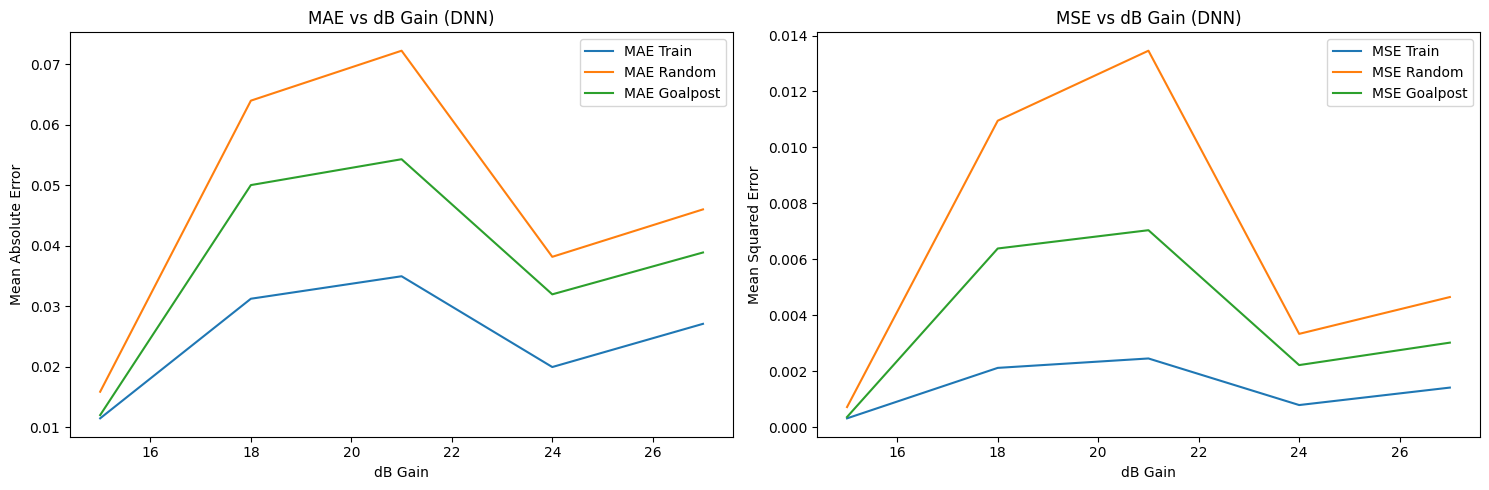

In [3]:
# Plot the results as line plots
plt.figure(figsize=(15, 5))

# MAE plot
plt.subplot(1, 2, 1)
plt.plot(db_values, mae_train_list_dnn, label='MAE Train')
plt.plot(db_values, mae_random_list_dnn, label='MAE Random')
plt.plot(db_values, mae_goalpost_list_dnn, label='MAE Goalpost')
plt.xlabel('dB Gain')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs dB Gain (DNN)')
plt.legend()

# MSE plot
plt.subplot(1, 2, 2)
plt.plot(db_values, mse_train_list_dnn, label='MSE Train')
plt.plot(db_values, mse_random_list_dnn, label='MSE Random')
plt.plot(db_values, mse_goalpost_list_dnn, label='MSE Goalpost')
plt.xlabel('dB Gain')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs dB Gain (DNN)')
plt.legend()

plt.tight_layout()
plt.show()

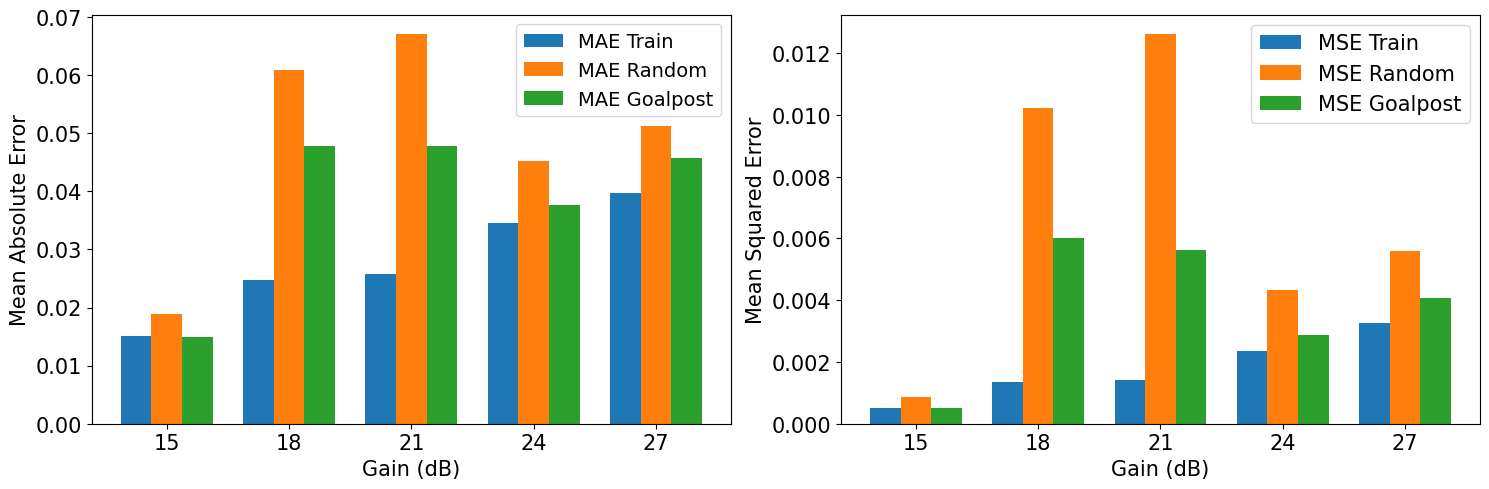

In [3]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

db_values = [15, 18, 21, 24, 27]

# Load the saved variables including the scaler
with open('dnn_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract the saved data
mae_train_list_dnn = results['mae_train_list_dnn']
mse_train_list_dnn = results['mse_train_list_dnn']
mae_random_list_dnn = results['mae_random_list_dnn']
mse_random_list_dnn = results['mse_random_list_dnn']
mae_goalpost_list_dnn = results['mae_goalpost_list_dnn']
mse_goalpost_list_dnn = results['mse_goalpost_list_dnn']
actual_gains_dnn = results['actual_gains_dnn']
dnn_predicted_gains = results['dnn_predicted_gains']
scaler = results['scaler']  # Load the saved scaler

# Plot the results as bar plots
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# MAE plot
plt.subplot(1, 2, 1)
bar_width = 0.25
index = np.arange(len(db_values))

plt.bar(index, mae_train_list_dnn, bar_width, label='MAE Train')  # Red
plt.bar(index + bar_width, mae_random_list_dnn, bar_width, label='MAE Random')  # Dark Gray
plt.bar(index + 2 * bar_width, mae_goalpost_list_dnn, bar_width, label='MAE Goalpost')  # Light Gray

plt.xlabel('Gain (dB)', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.xticks(index + bar_width, db_values)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# MSE plot
plt.subplot(1, 2, 2)

plt.bar(index, mse_train_list_dnn, bar_width, label='MSE Train')  # Red
plt.bar(index + bar_width, mse_random_list_dnn, bar_width, label='MSE Random')  # Dark Gray
plt.bar(index + 2 * bar_width, mse_goalpost_list_dnn, bar_width, label='MSE Goalpost')  # Light Gray

plt.xlabel('Gain (dB)', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=18)
plt.xticks(index + bar_width, db_values)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


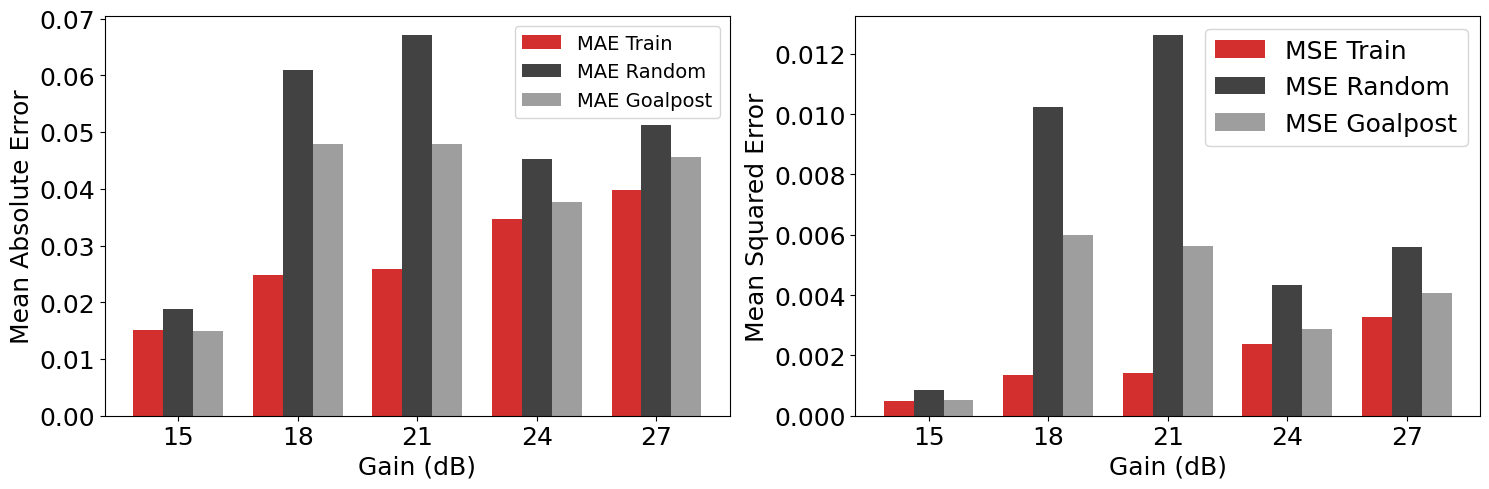

In [3]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

db_values = [15, 18, 21, 24, 27]

# Load the saved variables including the scaler
with open('dnn_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract the saved data
mae_train_list_dnn = results['mae_train_list_dnn']
mse_train_list_dnn = results['mse_train_list_dnn']
mae_random_list_dnn = results['mae_random_list_dnn']
mse_random_list_dnn = results['mse_random_list_dnn']
mae_goalpost_list_dnn = results['mae_goalpost_list_dnn']
mse_goalpost_list_dnn = results['mse_goalpost_list_dnn']
actual_gains_dnn = results['actual_gains_dnn']
dnn_predicted_gains = results['dnn_predicted_gains']
scaler = results['scaler']  # Load the saved scaler

# Plot the results as bar plots
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# MAE plot
plt.subplot(1, 2, 1)
bar_width = 0.25
index = np.arange(len(db_values))

plt.bar(index, mae_train_list_dnn, bar_width, color='#D32F2F', label='MAE Train')  # Red
plt.bar(index + bar_width, mae_random_list_dnn, bar_width, color='#424242', label='MAE Random')  # Dark Gray
plt.bar(index + 2 * bar_width, mae_goalpost_list_dnn, bar_width, color='#9E9E9E', label='MAE Goalpost')  # Light Gray

plt.xlabel('Gain (dB)', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.xticks(index + bar_width, db_values)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# MSE plot
plt.subplot(1, 2, 2)

plt.bar(index, mse_train_list_dnn, bar_width, color='#D32F2F', label='MSE Train')  # Red
plt.bar(index + bar_width, mse_random_list_dnn, bar_width, color='#424242', label='MSE Random')  # Dark Gray
plt.bar(index + 2 * bar_width, mse_goalpost_list_dnn, bar_width, color='#9E9E9E', label='MSE Goalpost')  # Light Gray

plt.xlabel('Gain (dB)', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=18)
plt.xticks(index + bar_width, db_values)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


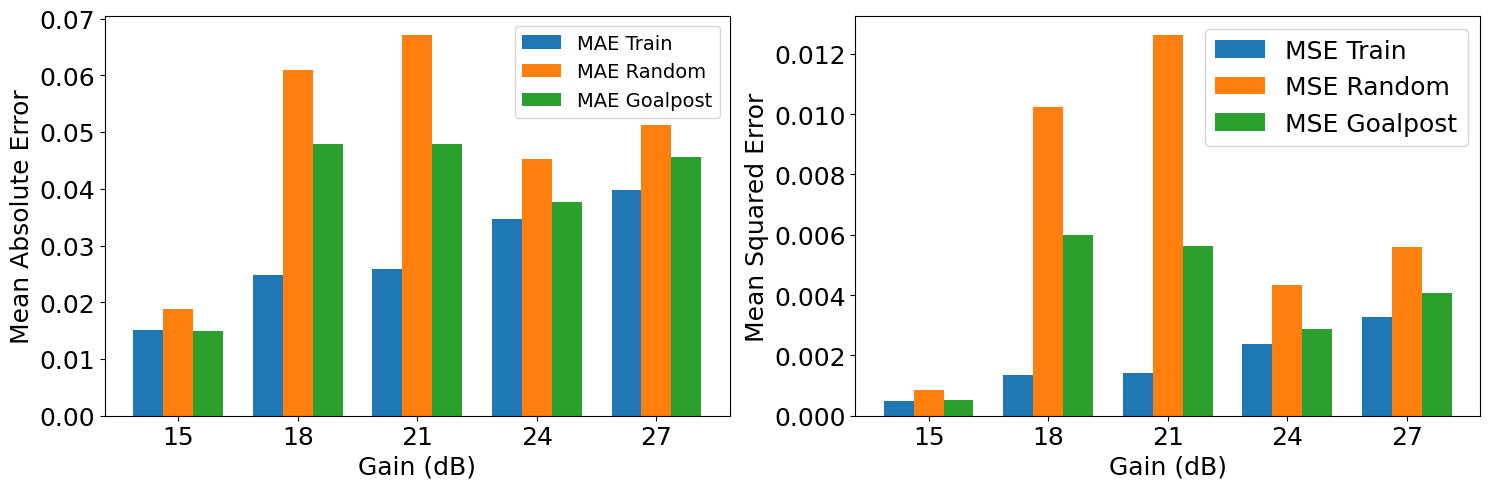

In [6]:
# Plot the results as bar plots
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15, 5))

# MAE plot
plt.subplot(1, 2, 1)
bar_width = 0.25
index = np.arange(len(db_values))

plt.bar(index, mae_train_list_dnn, bar_width, label='MAE Train')
plt.bar(index + bar_width, mae_random_list_dnn, bar_width, label='MAE Random')
plt.bar(index + 2 * bar_width, mae_goalpost_list_dnn, bar_width, label='MAE Goalpost')

plt.xlabel('Gain (dB)', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.xticks(index + bar_width, db_values)

plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# MSE plot
plt.subplot(1, 2, 2)

plt.bar(index, mse_train_list_dnn, bar_width, label='MSE Train')
plt.bar(index + bar_width, mse_random_list_dnn, bar_width, label='MSE Random')
plt.bar(index + 2 * bar_width, mse_goalpost_list_dnn, bar_width, label='MSE Goalpost')

plt.xlabel('Gain (dB)', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=18)
plt.xticks(index + bar_width, db_values)

plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

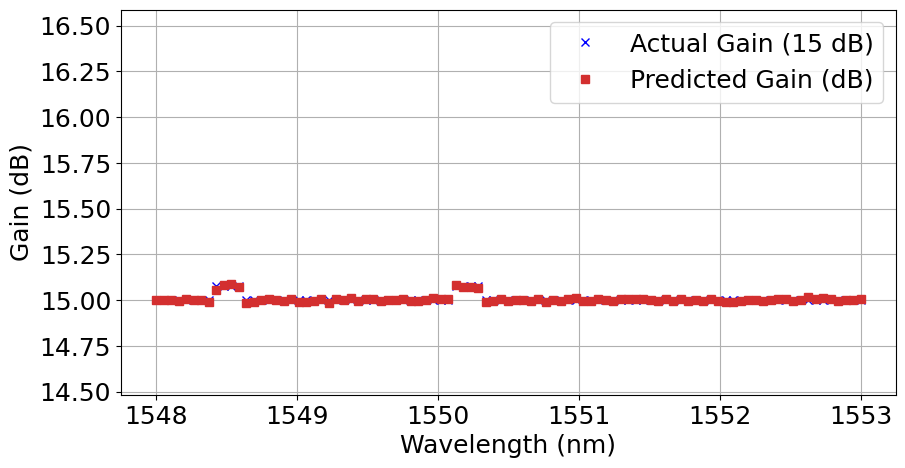

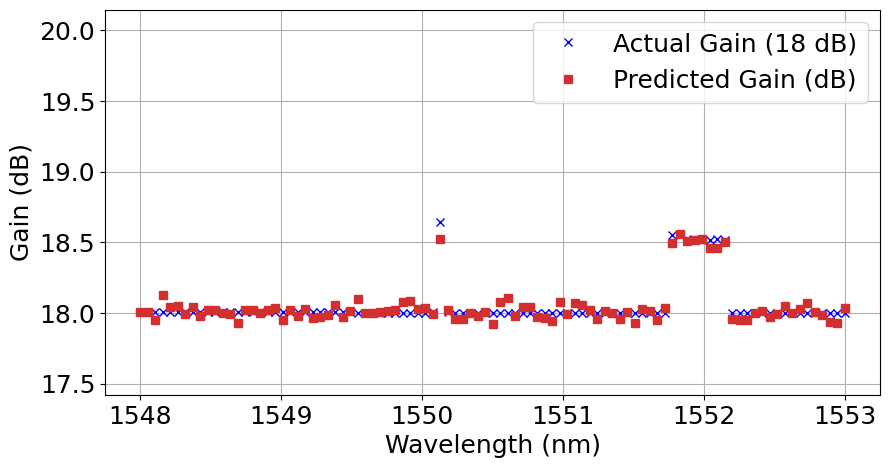

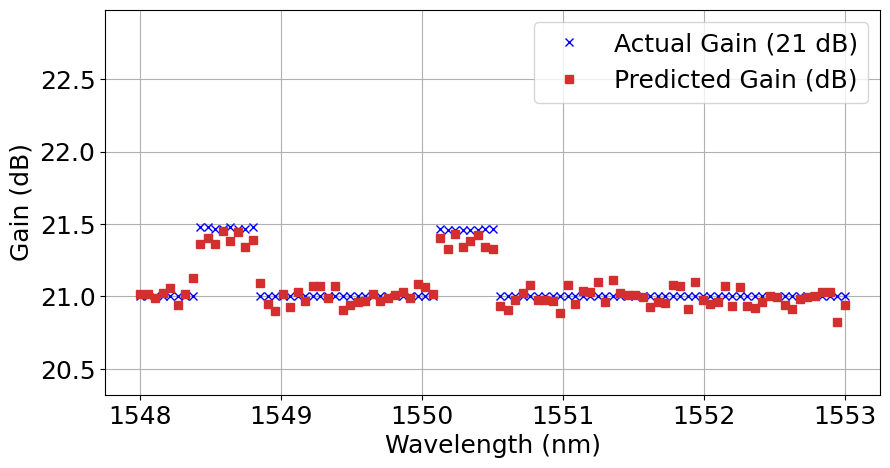

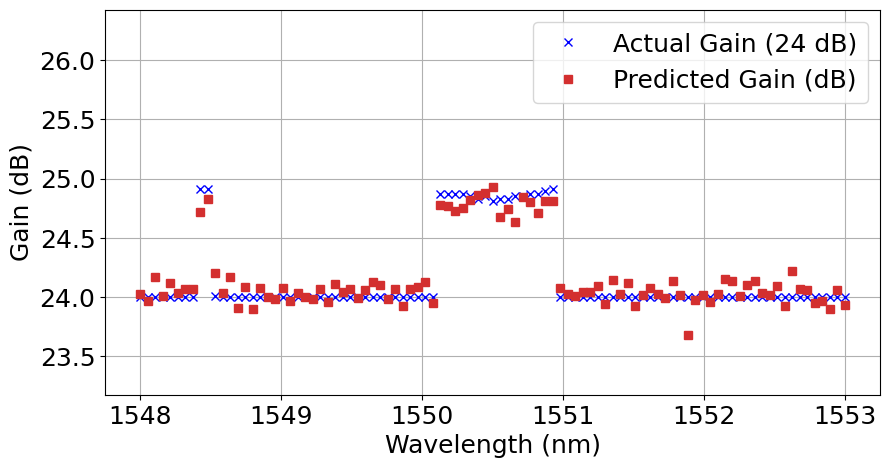

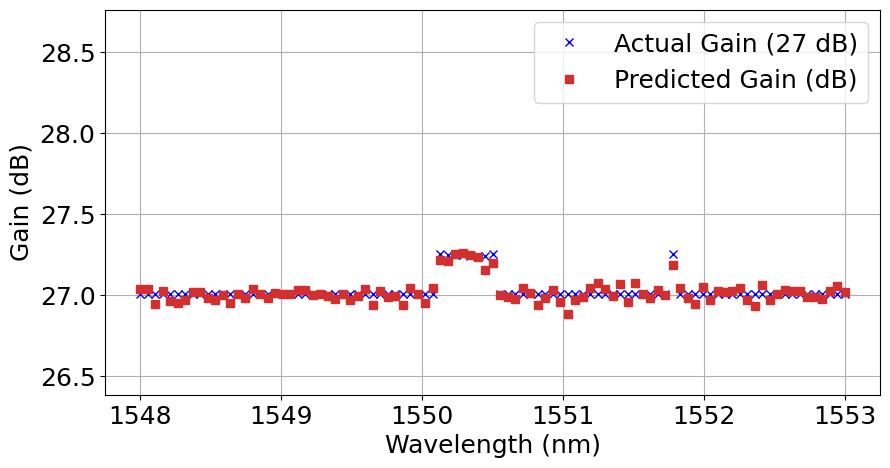

In [7]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

db_values = [15, 18, 21, 24, 27]

# Load the saved variables including the scaler
with open('dnn_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract the saved data
mae_train_list_dnn = results['mae_train_list_dnn']
mse_train_list_dnn = results['mse_train_list_dnn']
mae_random_list_dnn = results['mae_random_list_dnn']
mse_random_list_dnn = results['mse_random_list_dnn']
mae_goalpost_list_dnn = results['mae_goalpost_list_dnn']
mse_goalpost_list_dnn = results['mse_goalpost_list_dnn']
actual_gains_dnn = results['actual_gains_dnn']
dnn_predicted_gains = results['dnn_predicted_gains']
scaler = results['scaler']  # Load the saved scaler

# Loop through each dB value
for db in db_values:
    # Example of new data with 190 features
    # Concatenating the actual gains and predicted gains for each dB level as new data
    new_data = np.concatenate([actual_gains_dnn[db][:95].reshape(1, -1), dnn_predicted_gains[db][:95].reshape(1, -1)], axis=1)

    # Scaling the new data using the loaded scaler
    new_data_scaled = scaler.transform(new_data)

    # Inverse transform the scaled data back to the original scale
    predictions_original_scale = scaler.inverse_transform(new_data_scaled)

    # Add dB offset to the predictions and actual gains
    actual_gains_with_offset = predictions_original_scale[0, :95] + db
    predicted_gains_with_offset = predictions_original_scale[0, 95:] + db

    # Plotting actual vs predicted gains without MAE and MSE
    wavelengths = np.linspace(1548, 1553, 95)  # Assuming 95 channels

    plt.figure(figsize=(10, 5))
    
    # Plot actual gains with dB value in the label
    plt.plot(wavelengths, actual_gains_with_offset, 'x', label=f'Actual Gain ({db} dB)', color='blue')

    # Plot predicted gains with dB value in the label
    plt.plot(wavelengths, predicted_gains_with_offset, 's', label=f'Predicted Gain (dB)', color='#D32F2F')

    # Increase font size for labels
    plt.xlabel('Wavelength (nm)', fontsize=18)
    plt.ylabel('Gain (dB)', fontsize=18)
    
    # Increase font size for the legend and show the dB gain in it
    plt.legend(fontsize=18)
    plt.grid(True)

    # Set the y-axis limit with an additional gain (dB) value
    y_min = min(min(actual_gains_with_offset), min(predicted_gains_with_offset)) - 0.5
    y_max = max(max(actual_gains_with_offset), max(predicted_gains_with_offset)) + 1.5
    plt.ylim(y_min, y_max)

    # Increase font size for tick labels
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Show the plot
    plt.show()


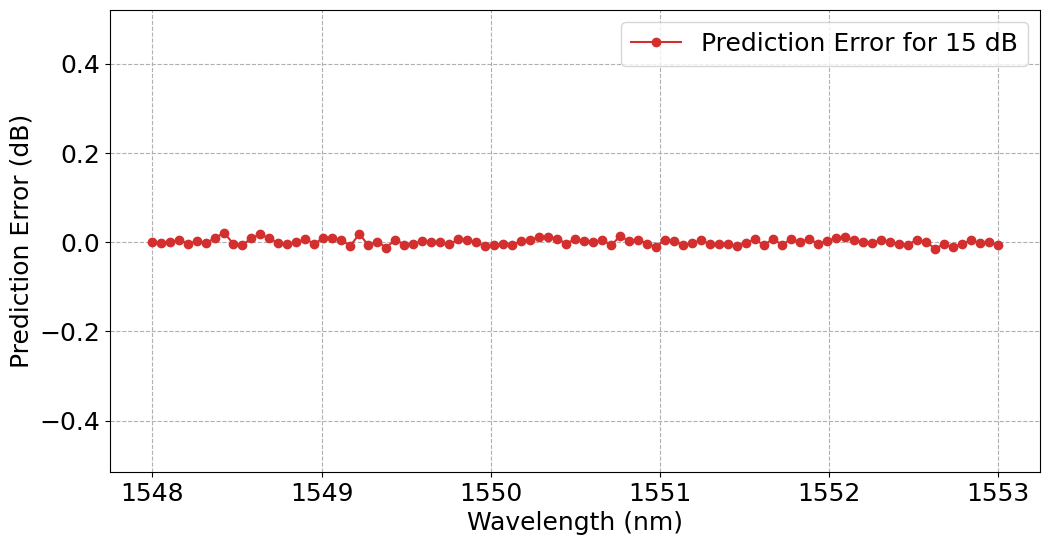

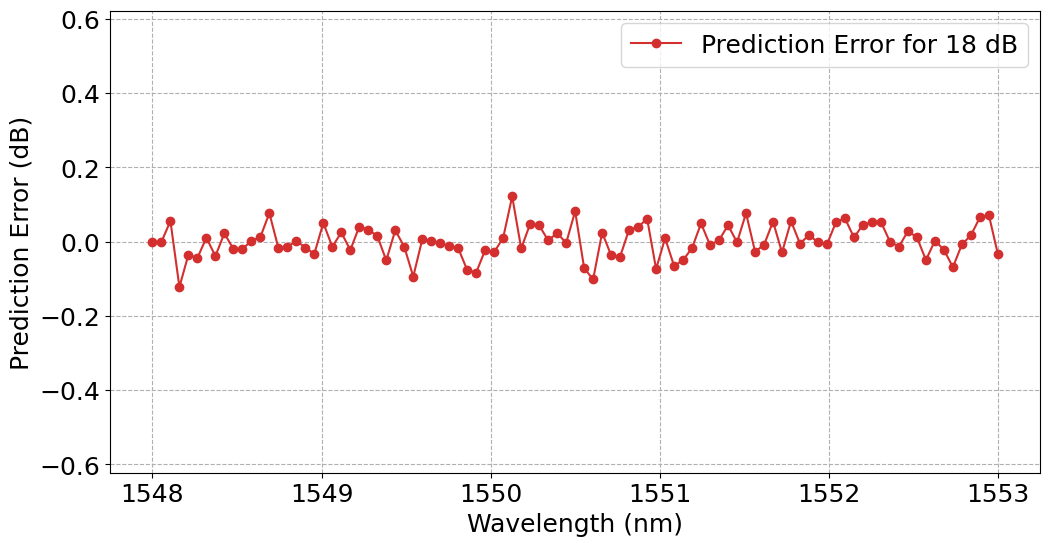

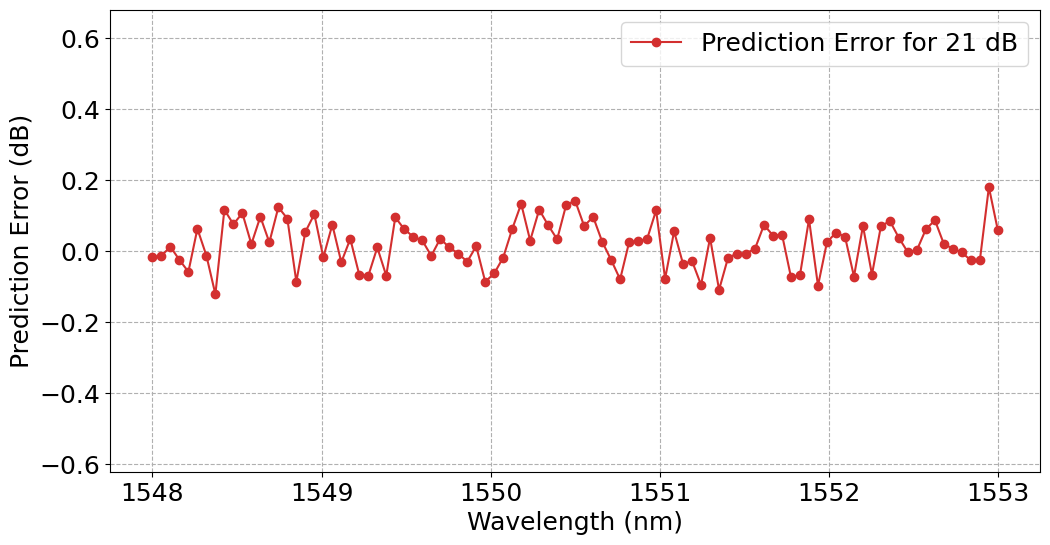

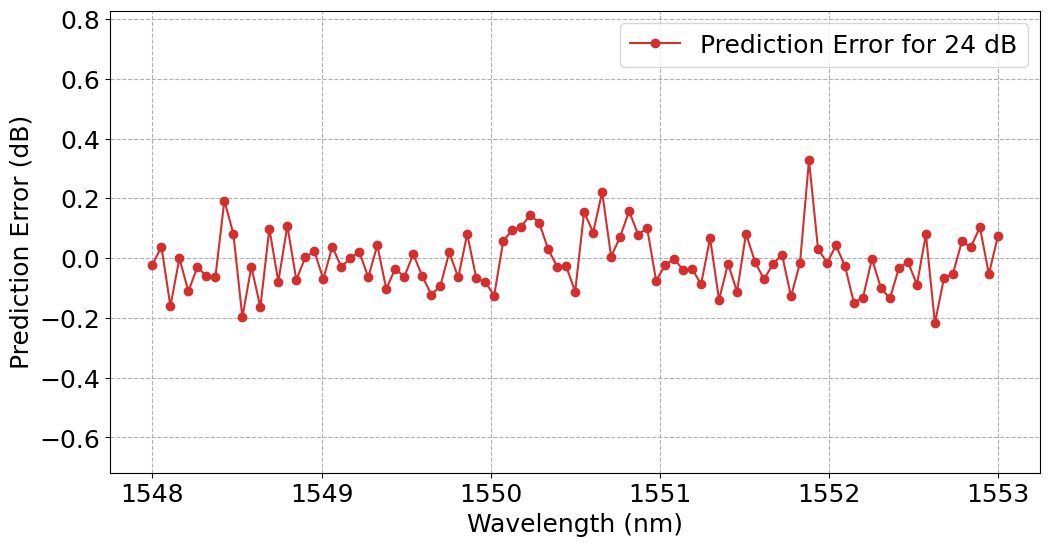

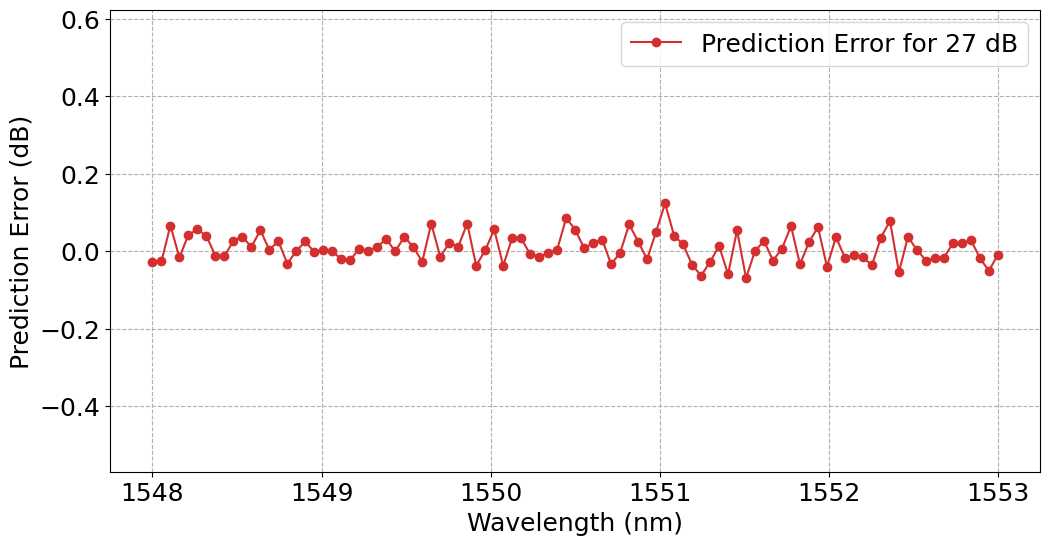

In [8]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

db_values = [15, 18, 21, 24, 27]
wavelengths = np.linspace(1548, 1553, 95)  # Assuming 95 wavelength channels

# Load the saved variables including the scaler
with open('dnn_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract the saved data
actual_gains_dnn = results['actual_gains_dnn']
dnn_predicted_gains = results['dnn_predicted_gains']
scaler = results['scaler']  # Load the saved scaler

# Loop through each dB value
for db in db_values:
    # Extract the actual and predicted gains
    actual_gains = actual_gains_dnn[db][:95]
    predicted_gains = dnn_predicted_gains[db][:95]

    # Calculate prediction error
    prediction_error = actual_gains - predicted_gains

    # Plotting prediction error vs wavelength
    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, prediction_error, label=f'Prediction Error for {db} dB', color='#D32F2F', marker='o')

    plt.xlabel('Wavelength (nm)', fontsize=18)
    plt.ylabel('Prediction Error (dB)', fontsize=18)
    
    # Set y-axis limits with 0.5 dB buffer on both sides
    y_min = min(prediction_error) - 0.5
    y_max = max(prediction_error) + 0.5
    plt.ylim(y_min, y_max)
    
    # Add grid and legend for clarity
    plt.grid(True, which="both", ls="--")
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.show()
